In [ ]:
%pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 32.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('ecoli_qsar_rascore.csv')
data.head()

,smiles,doi,id,group,group_name,MIC,lgMIC,scaffold,RAScore,SAScore,QED Score,MolWt,TPSA,HBD,HBA,RotatableBonds,LogP,SAS
0,O=C(OCC)C1=C(NC(=O)NC1C=2OC=CC2)CN3C=NC=4C=CC=...,10.1002/cjoc.202200326,5a,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1,pyrimidinone,0.174683,-0.757748,O=C1NC(Cn2cnc3ccccc32)=CC(c2ccco2)N1,0.594414,8.975830,0.676228,366.377,98.39,2.0,6.0,5.0,2.50060,3.004665
1,O=C(OCC)C1=C(N(C(=O)N(C1C2=CC=CS2)[H])[H])C[N]...,10.1002/cjoc.202200326,5b,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1,pyrimidinone,0.083672,-1.077419,O=C1NC(Cn2cnc3ccccc32)=CC(c2cccs2)N1,0.705063,8.975830,0.664583,382.445,85.25,2.0,6.0,5.0,2.96910,2.988643
2,O=C(OCC)C1=C(N(C(=O)N(C1C2=C(C=CS2)C)[H])[H])C...,10.1002/cjoc.202200326,5c,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1,pyrimidinone,0.080712,-1.093063,O=C1NC(Cn2cnc3ccccc32)=CC(c2cccs2)N1,0.420812,8.987137,0.648376,396.472,85.25,2.0,6.0,5.0,3.27752,3.109306
3,O=C(OCC)C1=C(N(C(=O)N(C1C2=CC=CS2)[H])[H])C[N]...,10.1002/cjoc.202200326,6a,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1,pyrimidinone,0.034682,-1.459902,O=C1NC(Cn2cnc3ccccc32)=CC(c2cccs2)N1,0.431898,8.987137,0.567505,461.341,85.25,2.0,6.0,5.0,3.73160,3.130328
4,O=C(OCC)C1=C(N(C(=O)N(C1C2=CC=CS2)[H])[H])C[N]...,10.1002/cjoc.202200326,6b,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1,pyrimidinone,0.037432,-1.426757,O=C1NC(Cn2cnc3ccccc32)=CC(c2cccs2)N1,0.193967,9.009649,0.353597,427.442,128.39,2.0,8.0,6.0,2.87730,3.182482


Adding chemical descriptors

SAscore

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Project/Оценка молекул/ecoli_qsar_rascore.csv')

import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import math

_fscores = None

def readFragmentScores():
    global _fscores
    _fscores = {}

def numBridgeheadsAndSpiro(mol, ri=None):
    if ri is None:
        ri = mol.GetRingInfo()
    atomRings = ri.AtomRings()
    nSpiro = 0
    nBridgeheads = 0
    return nBridgeheads, nSpiro

def calculateScore(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        if _fscores is None:
            readFragmentScores()

        # fragment score
        fp = rdMolDescriptors.GetMorganFingerprint(mol, 2)
        fps = fp.GetNonzeroElements()
        score1 = 0.0
        nf = 0
        for bitId, v in fps.items():
            nf += v
            sfp = bitId
            score1 += _fscores.get(sfp, -4) * v
        score1 /= nf

        # features score
        nAtoms = mol.GetNumAtoms()
        nChiralCenters = len(Chem.FindMolChiralCenters(mol, includeUnassigned=True))
        ri = mol.GetRingInfo()
        nBridgeheads, nSpiro = numBridgeheadsAndSpiro(mol, ri)
        nMacrocycles = 0
        for x in ri.AtomRings():
            if len(x) > 8:
                nMacrocycles += 1

        sizePenalty = nAtoms**1.005 - nAtoms
        stereoPenalty = math.log10(nChiralCenters + 1)
        spiroPenalty = math.log10(nSpiro + 1)
        bridgePenalty = math.log10(nBridgeheads + 1)
        macrocyclePenalty = 0.0

        if nMacrocycles > 0:
            macrocyclePenalty = math.log10(2)

        score2 = -sizePenalty - stereoPenalty - spiroPenalty - bridgePenalty - macrocyclePenalty

        # correction for the fingerprint density
        score3 = 0.0
        if nAtoms > len(fps):
            score3 = math.log(float(nAtoms) / len(fps)) * 0.5

        sascore = score1 + score2 + score3

        # Transform "raw" value into scale between 1 and 10
        min_val = -4.0
        max_val = 2.5
        sascore = 11.0 - (sascore - min_val + 1.0) / (max_val - min_val) * 9.0

        if sascore > 8.0:
            sascore = 8.0 + math.log(sascore + 1.0 - 9.0)
        if sascore > 10.0:
            sascore = 10.0
        elif sascore < 1.0:
            sascore = 1.0

        return sascore

    except Exception as e:
        print(f"Ошибка при вычислении SA Score для SMILES {smiles}: {e}")
        return None

df['SAScore'] = df['smiles'].apply(calculateScore)

df.to_csv('/content/drive/MyDrive/Project/Оценка молекул/ecoli_qsar_rascore.csv', index=False)

[15:45:56] DEPRECATION WARNING: please use MorganGenerator
[15:45:56] DEPRECATION WARNING: please use MorganGenerator
[15:45:56] DEPRECATION WARNING: please use MorganGenerator
[15:45:56] DEPRECATION WARNING: please use MorganGenerator
[15:45:56] DEPRECATION WARNING: please use MorganGenerator
[15:45:56] DEPRECATION WARNING: please use MorganGenerator
[15:45:56] DEPRECATION WARNING: please use MorganGenerator
[15:45:56] DEPRECATION WARNING: please use MorganGenerator
[15:45:56] DEPRECATION WARNING: please use MorganGenerator
[15:45:56] DEPRECATION WARNING: please use MorganGenerator
[15:45:56] DEPRECATION WARNING: please use MorganGenerator
[15:45:56] DEPRECATION WARNING: please use MorganGenerator
[15:45:56] DEPRECATION WARNING: please use MorganGenerator
[15:45:56] DEPRECATION WARNING: please use MorganGenerator
[15:45:57] DEPRECATION WARNING: please use MorganGenerator
[15:45:57] DEPRECATION WARNING: please use MorganGenerator
[15:45:57] DEPRECATION WARNING: please use MorganGenerat

SAS

In [ ]:
import sys, os
from rdkit.Chem import RDConfig
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

def check_sascore(mol):
  """ Calculates SAScore """
  return sascorer.calculateScore(mol)

QED

In [ ]:
import os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors

df = pd.read_csv('/content/drive/MyDrive/Project/Оценка молекул/ecoli_qsar_rascore.csv')

def check_qed(mol):
    """Calculates QED-score."""
    return Descriptors.qed(mol)

def process_molecule(smiles):
    if isinstance(smiles, str) and smiles.strip():
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            qed_score = check_qed(mol)
            return qed_score
    return None
df['QED Score'] = None


for index, row in df.iterrows():
    smiles = row['smiles']
    qed_score = process_molecule(smiles)


    df.at[index, 'QED Score'] = qed_score


df.to_csv('/content/drive/MyDrive/Project/Оценка молекул/ecoli_qsar_rascore.csv', index=False)

df.head()


,smiles,doi,id,group,group_name,MIC,lgMIC,scaffold,RAScore,SAScore,QED Score
0,O=C(OCC)C1=C(NC(=O)NC1C=2OC=CC2)CN3C=NC=4C=CC=...,10.1002/cjoc.202200326,5a,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1,pyrimidinone,0.174683,-0.757748,O=C1NC(Cn2cnc3ccccc32)=CC(c2ccco2)N1,0.594414,8.975830,0.676228
1,O=C(OCC)C1=C(N(C(=O)N(C1C2=CC=CS2)[H])[H])C[N]...,10.1002/cjoc.202200326,5b,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1,pyrimidinone,0.083672,-1.077419,O=C1NC(Cn2cnc3ccccc32)=CC(c2cccs2)N1,0.705063,8.975830,0.664583
2,O=C(OCC)C1=C(N(C(=O)N(C1C2=C(C=CS2)C)[H])[H])C...,10.1002/cjoc.202200326,5c,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1,pyrimidinone,0.080712,-1.093063,O=C1NC(Cn2cnc3ccccc32)=CC(c2cccs2)N1,0.420812,8.987137,0.648376
3,O=C(OCC)C1=C(N(C(=O)N(C1C2=CC=CS2)[H])[H])C[N]...,10.1002/cjoc.202200326,6a,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1,pyrimidinone,0.034682,-1.459902,O=C1NC(Cn2cnc3ccccc32)=CC(c2cccs2)N1,0.431898,8.987137,0.567505
4,O=C(OCC)C1=C(N(C(=O)N(C1C2=CC=CS2)[H])[H])C[N]...,10.1002/cjoc.202200326,6b,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1,pyrimidinone,0.037432,-1.426757,O=C1NC(Cn2cnc3ccccc32)=CC(c2cccs2)N1,0.193967,9.009649,0.353597


Other descriptors

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors

df = pd.read_csv('/content/drive/MyDrive/Project/Оценка молекул/ecoli_qsar_rascore.csv')

def calculate_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            mol_wt = Descriptors.MolWt(mol)
            tpsa = Descriptors.TPSA(mol)
            hbd = Descriptors.NumHDonors(mol)
            hba = Descriptors.NumHAcceptors(mol)
            rotatable_bonds = Descriptors.NumRotatableBonds(mol)
            logp = Descriptors.MolLogP(mol)
            return pd.Series([mol_wt, tpsa, hbd, hba, rotatable_bonds, logp])
        else:
            return pd.Series([None] * 6)
    except Exception as e:
        return pd.Series([None] * 6)  # return None if mistake

df[['MolWt', 'TPSA', 'HBD', 'HBA', 'RotatableBonds', 'LogP']] = df['smiles'].apply(calculate_descriptors)

df.to_csv('/content/drive/MyDrive/Project/Оценка молекул/ecoli_qsar_rascore.csv', index=False)
df.head()

,smiles,doi,id,group,group_name,MIC,lgMIC,scaffold,RAScore,SAScore,QED Score,MolWt,TPSA,HBD,HBA,RotatableBonds,LogP
0,O=C(OCC)C1=C(NC(=O)NC1C=2OC=CC2)CN3C=NC=4C=CC=...,10.1002/cjoc.202200326,5a,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1,pyrimidinone,0.174683,-0.757748,O=C1NC(Cn2cnc3ccccc32)=CC(c2ccco2)N1,0.594414,8.975830,0.676228,366.377,98.39,2.0,6.0,5.0,2.50060
1,O=C(OCC)C1=C(N(C(=O)N(C1C2=CC=CS2)[H])[H])C[N]...,10.1002/cjoc.202200326,5b,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1,pyrimidinone,0.083672,-1.077419,O=C1NC(Cn2cnc3ccccc32)=CC(c2cccs2)N1,0.705063,8.975830,0.664583,382.445,85.25,2.0,6.0,5.0,2.96910
2,O=C(OCC)C1=C(N(C(=O)N(C1C2=C(C=CS2)C)[H])[H])C...,10.1002/cjoc.202200326,5c,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1,pyrimidinone,0.080712,-1.093063,O=C1NC(Cn2cnc3ccccc32)=CC(c2cccs2)N1,0.420812,8.987137,0.648376,396.472,85.25,2.0,6.0,5.0,3.27752
3,O=C(OCC)C1=C(N(C(=O)N(C1C2=CC=CS2)[H])[H])C[N]...,10.1002/cjoc.202200326,6a,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1,pyrimidinone,0.034682,-1.459902,O=C1NC(Cn2cnc3ccccc32)=CC(c2cccs2)N1,0.431898,8.987137,0.567505,461.341,85.25,2.0,6.0,5.0,3.73160
4,O=C(OCC)C1=C(N(C(=O)N(C1C2=CC=CS2)[H])[H])C[N]...,10.1002/cjoc.202200326,6b,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1,pyrimidinone,0.037432,-1.426757,O=C1NC(Cn2cnc3ccccc32)=CC(c2cccs2)N1,0.193967,9.009649,0.353597,427.442,128.39,2.0,8.0,6.0,2.87730


Количество строк с group_name "quinoline" или "quinolone": 118


<ipython-input-15-bd80b2311bc7>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='SAScore', data=data_sascore, palette=['dimgray', '#FF69B4'], showfliers=False)  # Убираем выбросы
<ipython-input-15-bd80b2311bc7>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='QED Score', data=data_qed, palette=['dimgray', '#FF69B4'], showfliers=False)  # Убираем выбросы
<ipython-input-15-bd80b2311bc7>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='RAScore', data=data_rascore, palette=['dimgray', '#FF69B4'], show

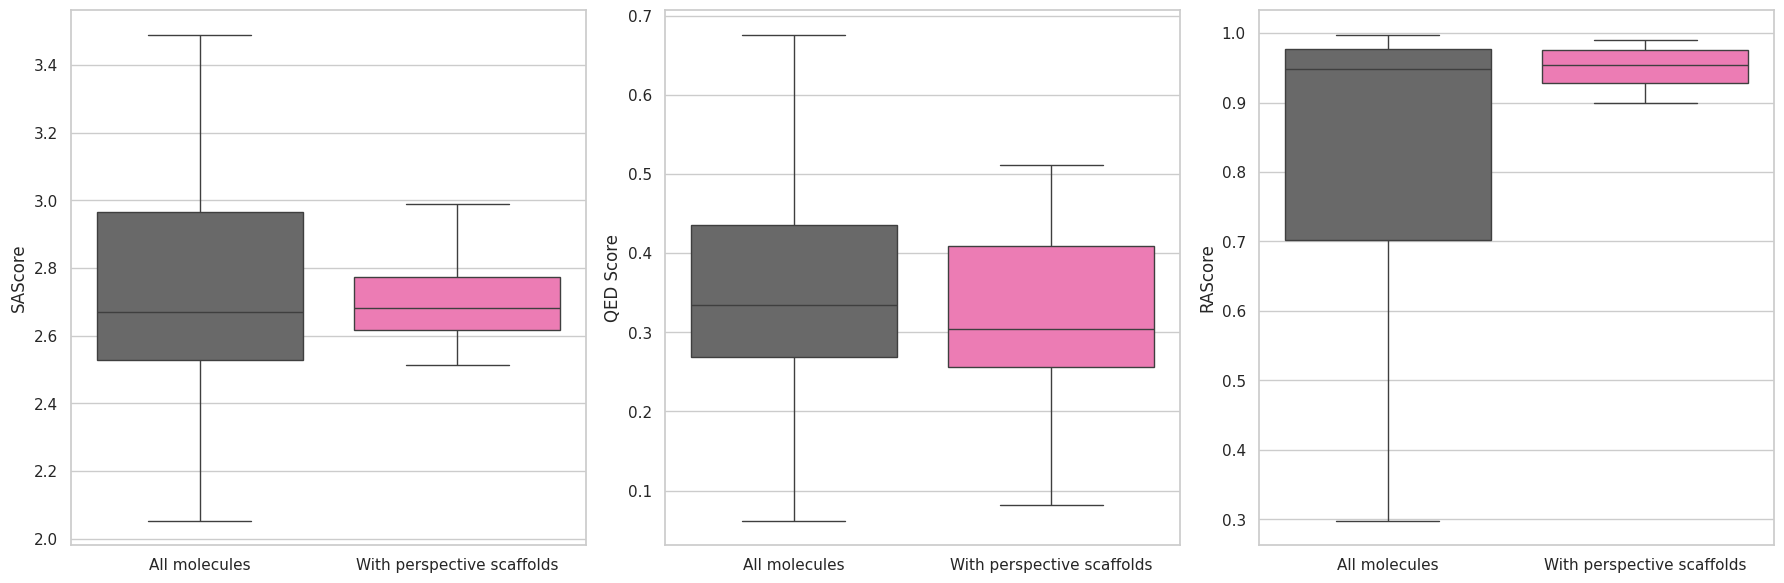

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Project/Оценка молекул/ecoli_qsar_rascore.csv')

df_scaffold = df[df['group_name'].str.contains('quinoline|quinolone', case=False, na=False)]

print(f'Количество строк с group_name "quinoline" или "quinolone": {len(df_scaffold)}')

sns.set(style="whitegrid")

data_sascore = pd.DataFrame({
    'SAScore': pd.concat([df['SAS'].dropna(), df_scaffold['SAS'].dropna()]),
    'Group': ['All molecules'] * len(df['SAS'].dropna()) + ['With perspective scaffolds'] * len(df_scaffold['SAS'].dropna())
})

data_qed = pd.DataFrame({
    'QED Score': pd.concat([df['QED Score'].dropna(), df_scaffold['QED Score'].dropna()]),
    'Group': ['All molecules'] * len(df['QED Score'].dropna()) + ['With perspective scaffolds'] * len(df_scaffold['QED Score'].dropna())
})

data_rascore = pd.DataFrame({
    'RAScore': pd.concat([df['RAScore'].dropna(), df_scaffold['RAScore'].dropna()]),
    'Group': ['All molecules'] * len(df['RAScore'].dropna()) + ['With perspective scaffolds'] * len(df_scaffold['RAScore'].dropna())
})

plt.figure(figsize=(18, 6))

# SAScore
plt.subplot(1, 3, 1)
sns.boxplot(x='Group', y='SAScore', data=data_sascore, palette=['dimgray', '#FF69B4'], showfliers=False)  # Убираем выбросы
plt.ylabel('SAScore')
plt.xlabel('')  # Убираем название для оси X

# QED Score
plt.subplot(1, 3, 2)
sns.boxplot(x='Group', y='QED Score', data=data_qed, palette=['dimgray', '#FF69B4'], showfliers=False)  # Убираем выбросы
plt.ylabel('QED Score')
plt.xlabel('')  # Убираем название для оси X

# RAScore
plt.subplot(1, 3, 3)
sns.boxplot(x='Group', y='RAScore', data=data_rascore, palette=['dimgray', '#FF69B4'], showfliers=False)  # Убираем выбросы
plt.ylabel('RAScore')
plt.xlabel('')  # Убираем название для оси X

plt.tight_layout()
plt.show()


Количество строк с group_name "quinoline" или "quinolone": 118


<ipython-input-4-20f05f4f6c34>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y='SAScore', data=data, palette=['dimgray', '#FF69B4'], inner='quartile')  # Возвращаем контуры и линии внутри
<ipython-input-4-20f05f4f6c34>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y='QED Score', data=data, palette=['dimgray', '#FF69B4'], inner='quartile')  # Возвращаем контуры и линии внутри


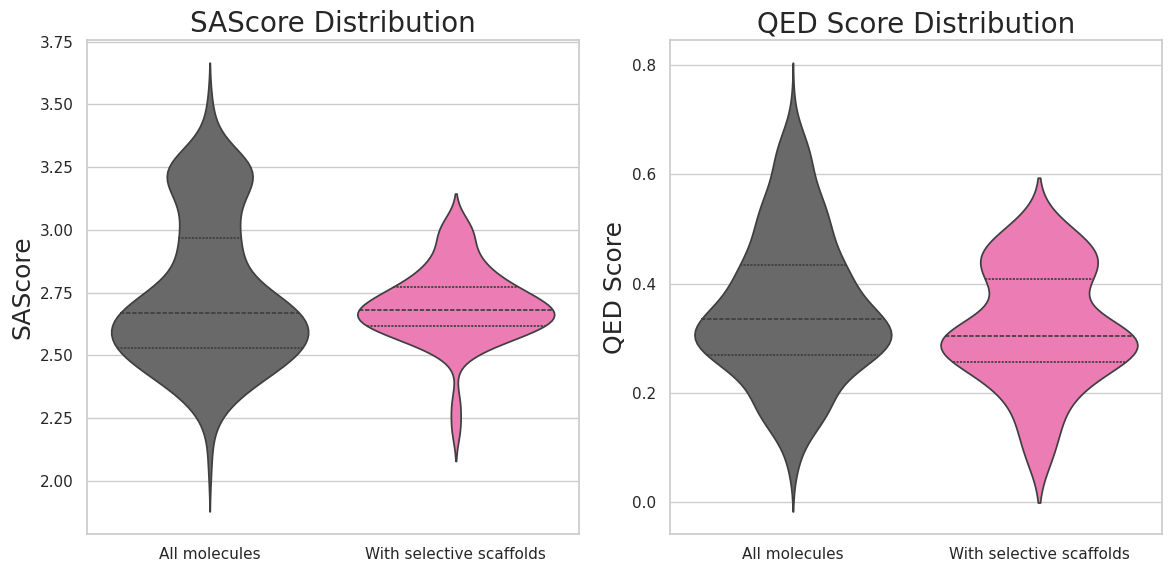

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Project/Оценка молекул/ecoli_qsar_rascore.csv')

df_scaffold = df[df['group_name'].str.contains('quinoline|quinolone', case=False, na=False)]

print(f'Количество строк с group_name "quinoline" или "quinolone": {len(df_scaffold)}')

sns.set(style="whitegrid")

plt.rcParams.update({'font.size': 16})  # Увеличьте размер шрифта по умолчанию

data = pd.DataFrame({
    'SAScore': pd.concat([df['SAS'].dropna(), df_scaffold['SAS'].dropna()]),
    'QED Score': pd.concat([df['QED Score'].dropna(), df_scaffold['QED Score'].dropna()]),
    'Group': ['All molecules'] * len(df['SAS'].dropna()) + ['With selective scaffolds'] * len(df_scaffold['SAS'].dropna())
})

plt.figure(figsize=(12, 6))

# Violin plot для SAScore
plt.subplot(1, 2, 1)
sns.violinplot(x='Group', y='SAScore', data=data, palette=['dimgray', '#FF69B4'], inner='quartile')  # Возвращаем контуры и линии внутри
plt.ylabel('SAScore', fontsize=18)  # Увеличение размера шрифта для оси Y
plt.title('SAScore Distribution', fontsize=20)  # Увеличение размера шрифта заголовка
plt.xlabel('', fontsize=18)  # Убираем подпись для оси X

# Violin plot для QED Score
plt.subplot(1, 2, 2)
sns.violinplot(x='Group', y='QED Score', data=data, palette=['dimgray', '#FF69B4'], inner='quartile')  # Возвращаем контуры и линии внутри
plt.ylabel('QED Score', fontsize=18)  # Увеличение размера шрифта для оси Y
plt.title('QED Score Distribution', fontsize=20)  # Увеличение размера шрифта заголовка
plt.xlabel('', fontsize=18)  # Убираем подпись для оси X

plt.tight_layout()
plt.show()

SA Score

In [ ]:
import sys, os
from rdkit.Chem import RDConfig
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

def check_sascore(mol):
  """ Calculates SAScore """
  return sascorer.calculateScore(mol)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Project/Оценка молекул/ecoli_qsar_rascore.csv')

df['new_SAScore'] = df['smiles'].apply(lambda x: check_sascore(x))

df.head()
df.to_csv("/content/drive/MyDrive/Project/Оценка молекул/ecoli_qsar_rascore.csv", index=False)

ArgumentError: Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprint(str, int)
did not match C++ signature:
    GetMorganFingerprint(RDKit::ROMol mol, unsigned int radius, boost::python::api::object invariants=[], boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, bool useCounts=True, boost::python::api::object bitInfo=None, bool includeRedundantEnvironments=False)

In [ ]:
import sys
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import RDConfig
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

def check_sascore(mol):
    """ Calculates SAScore """
    return sascorer.calculateScore(mol)

def calculate_sascores(df):
    """ Applies SAScore calculation to the smiles column of the DataFrame. """
    df['SAS'] = df['smiles'].apply(lambda x: check_sascore(Chem.MolFromSmiles(x)) if x else None)
    return df

df = pd.read_csv('/content/drive/MyDrive/Project/Оценка молекул/ecoli_qsar_rascore.csv')  # Замените на путь к вашему файлу

df_with_sas = calculate_sascores(df)

df_with_sas.head()
df_with_sas.to_csv('/content/drive/MyDrive/Project/Оценка молекул/ecoli_qsar_rascore.csv', index=False)

[20:42:53] DEPRECATION WARNING: please use MorganGenerator
[20:42:53] DEPRECATION WARNING: please use MorganGenerator
[20:42:53] DEPRECATION WARNING: please use MorganGenerator
[20:42:53] DEPRECATION WARNING: please use MorganGenerator
[20:42:53] DEPRECATION WARNING: please use MorganGenerator
[20:42:53] DEPRECATION WARNING: please use MorganGenerator
[20:42:53] DEPRECATION WARNING: please use MorganGenerator
[20:42:53] DEPRECATION WARNING: please use MorganGenerator
[20:42:53] DEPRECATION WARNING: please use MorganGenerator
[20:42:53] DEPRECATION WARNING: please use MorganGenerator
[20:42:53] DEPRECATION WARNING: please use MorganGenerator
[20:42:53] DEPRECATION WARNING: please use MorganGenerator
[20:42:53] DEPRECATION WARNING: please use MorganGenerator
[20:42:53] DEPRECATION WARNING: please use MorganGenerator
[20:42:53] DEPRECATION WARNING: please use MorganGenerator
[20:42:53] DEPRECATION WARNING: please use MorganGenerator
[20:42:53] DEPRECATION WARNING: please use MorganGenerat

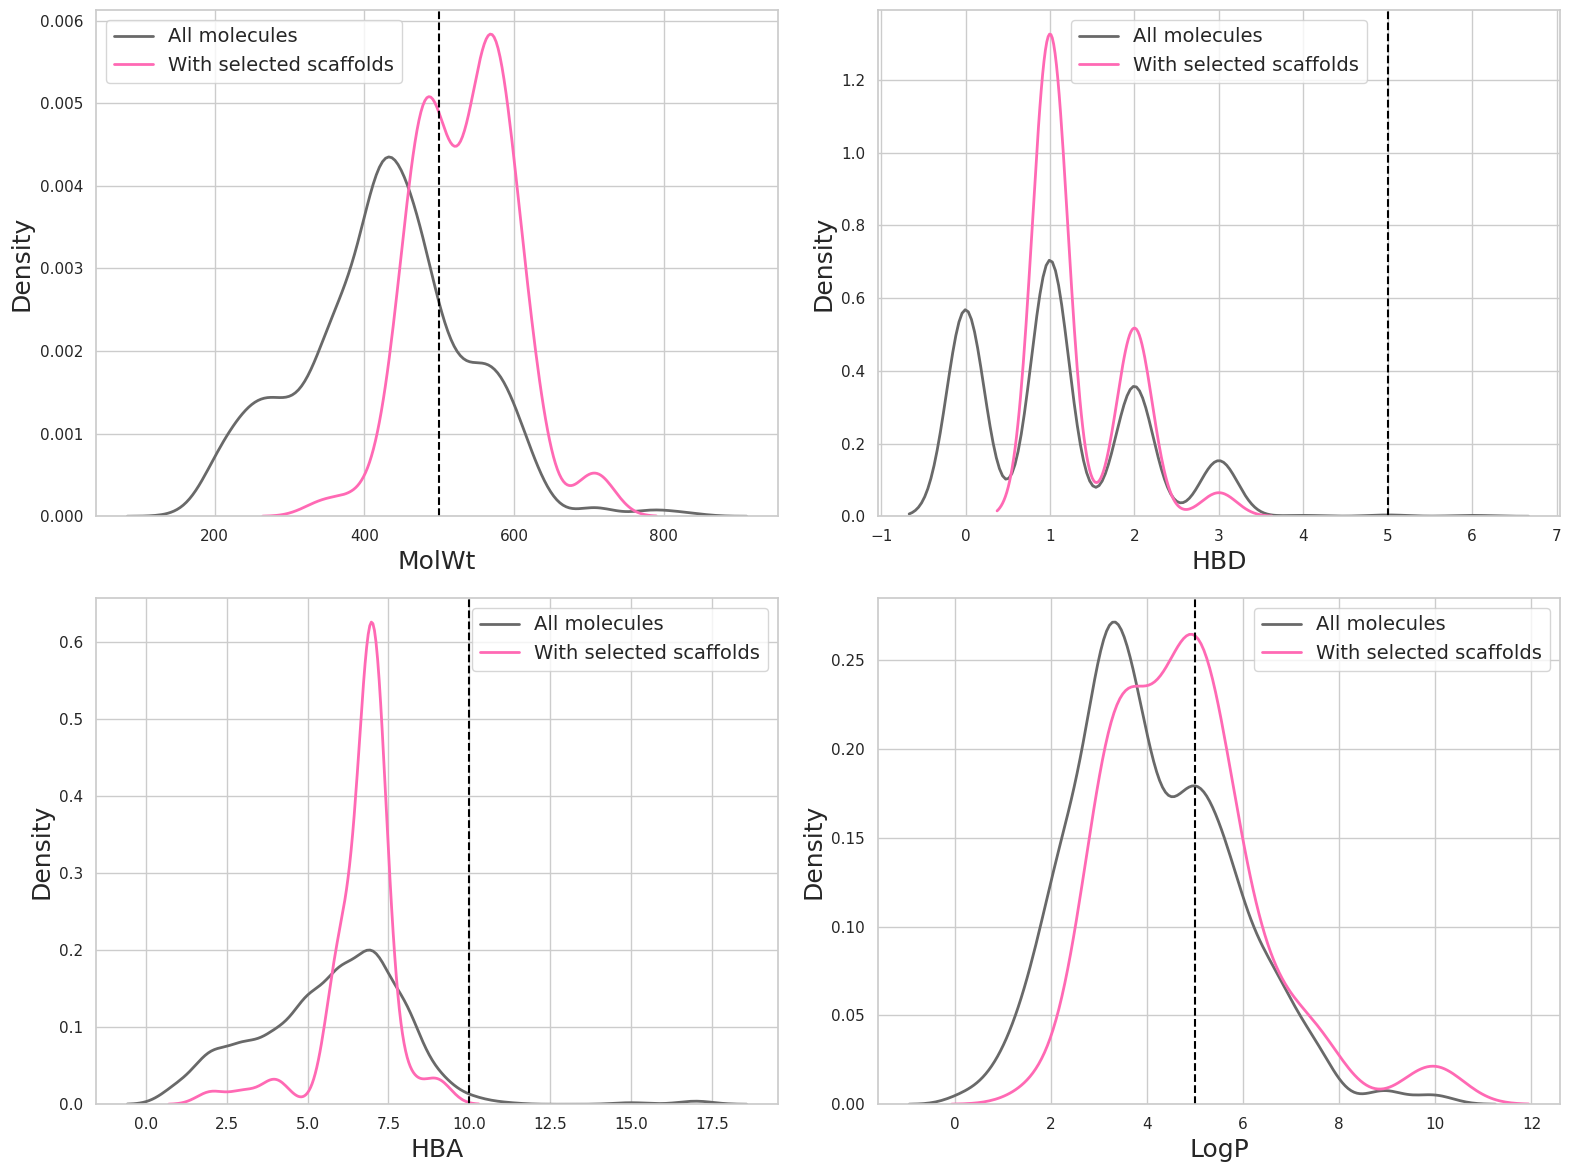

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Project/Оценка молекул/new_Benzimidazole_dataset - new_Benzimidazole_dataset.csv')

df_scaffold = df[df['group_name'].str.contains('quinoline|quinolone', case=False, na=False)]

sns.set(style="whitegrid")

plt.rcParams.update({'font.size': 16})  # Увеличьте размер шрифта по умолчанию

plt.figure(figsize=(16, 12))

# Molecular Weight (MolWt)
plt.subplot(2, 2, 1)
sns.kdeplot(df['MolWt'], color='dimgray', linewidth=2, label='All molecules')  # Тёмно-серый
sns.kdeplot(df_scaffold['MolWt'], color='#FF69B4', linewidth=2, label='With selected scaffolds')  # Ярко-розовый
plt.axvline(500, color='black', linestyle='--')  # Пунктирная линия для MolWt
plt.xlabel('MolWt', fontsize=18)  # Увеличение размера шрифта для оси X
plt.ylabel('Density', fontsize=18)  # Увеличение размера шрифта для оси Y
plt.legend(fontsize=14)  # Увеличение размера шрифта для легенды

# Number of Hydrogen Bond Donors (HBD)
plt.subplot(2, 2, 2)
sns.kdeplot(df['HBD'], color='dimgray', linewidth=2, label='All molecules')  # Тёмно-серый
sns.kdeplot(df_scaffold['HBD'], color='#FF69B4', linewidth=2, label='With selected scaffolds')  # Ярко-розовый
plt.axvline(5, color='black', linestyle='--')  # Пунктирная линия для HDonors
plt.xlabel('HBD', fontsize=18)  # Увеличение размера шрифта для оси X
plt.ylabel('Density', fontsize=18)  # Увеличение размера шрифта для оси Y
plt.legend(fontsize=14)  # Увеличение размера шрифта для легенды

# Number of Hydrogen Bond Acceptors (HBA)
plt.subplot(2, 2, 3)
sns.kdeplot(df['HBA'], color='dimgray', linewidth=2, label='All molecules')  # Тёмно-серый
sns.kdeplot(df_scaffold['HBA'], color='#FF69B4', linewidth=2, label='With selected scaffolds')  # Ярко-розовый
plt.axvline(10, color='black', linestyle='--')  # Пунктирная линия для HAcceptors
plt.xlabel('HBA', fontsize=18)  # Увеличение размера шрифта для оси X
plt.ylabel('Density', fontsize=18)  # Увеличение размера шрифта для оси Y
plt.legend(fontsize=14)  # Увеличение размера шрифта для легенды

# LogP
plt.subplot(2, 2, 4)
sns.kdeplot(df['LogP'], color='dimgray', linewidth=2, label='All molecules')  # Тёмно-серый
sns.kdeplot(df_scaffold['LogP'], color='#FF69B4', linewidth=2, label='With selected scaffolds')  # Ярко-розовый
plt.axvline(5, color='black', linestyle='--')  # Пунктирная линия для LogP
plt.xlabel('LogP', fontsize=18)  # Увеличение размера шрифта для оси X
plt.ylabel('Density', fontsize=18)  # Увеличение размера шрифта для оси Y
plt.legend(fontsize=14)  # Увеличение размера шрифта для легенды

plt.tight_layout()
plt.show()